# Imports

In [5]:
import re
from unicodedata import normalize
import html
from tqdm.notebook import tqdm
import pickle
import gc
from itertools import compress
import spacy
import pandas as pd
import numpy as np

import seaborn as sns

from PIL import Image 
from wordcloud import WordCloud, STOPWORDS

from collections import OrderedDict, defaultdict
from operator import itemgetter  

import matplotlib.pyplot as plt

# Load articles

In [5]:
df_wikimusica = pickle.load(open("../Data/df_wikimusica_long.p", "rb"))

___

In [6]:
def get_length(text: str):
    try:
        return len(text)
    except:
        return 0

In [7]:
#dataset_target['length'] = dataset_target['first_sentence'].apply(get_length)
df_wikimusica['length'] = df_wikimusica['text'].apply(get_length)

In [8]:
df_wikimusica.head()

,_id_,_titulo_,_url_,variable,value,text,length
0,4511,Mike Oldfield,https://es.wikipedia.org/wiki?curid=4511,nombre artistico,Mike Oldfield,"Michael Gordon Oldfield (Reading, Reino Unido,...",264
1,4715,Shakira,https://es.wikipedia.org/wiki?curid=4715,nombre artistico,Shakira,"Shakira Isabel Mebarak Ripoll (Barranquilla, C...",246
2,4715,Shakira,https://es.wikipedia.org/wiki?curid=4715,nombre artistico,Shak,"Shakira Isabel Mebarak Ripoll (Barranquilla, C...",246
3,4715,Shakira,https://es.wikipedia.org/wiki?curid=4715,nombre artistico,Shaki,"Shakira Isabel Mebarak Ripoll (Barranquilla, C...",246
4,4715,Shakira,https://es.wikipedia.org/wiki?curid=4715,nombre artistico,Reina del pop latino,"Shakira Isabel Mebarak Ripoll (Barranquilla, C...",246


## DATASET DESCRIPTION

## Full length

In [9]:
df_text = df_wikimusica.filter(['text', '_id_', 'length'])
df_text.drop_duplicates(inplace=True)

### Text length

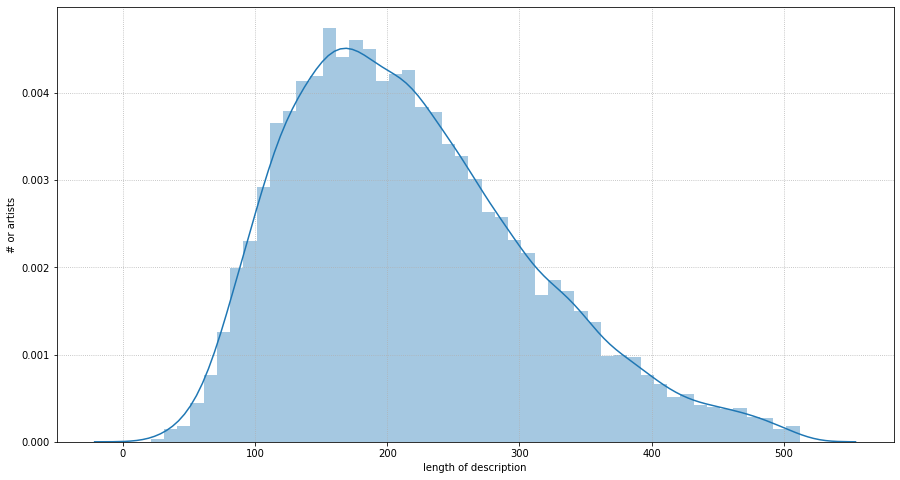

In [11]:
plt.figure(figsize=(15, 8))

#plt.hist(df_text['length'], bins=80, color='sienna')

#sns.distplot(df_text['length'], kde=True, color='sienna')
sns.distplot(df_text['length'], kde=True)

plt.grid(linestyle=':')
plt.ylabel('# or artists')
plt.xlabel('length of description')
plt.show()

___

### Create tokens

In [13]:
%%time

nlp = spacy.load('es_core_news_sm')
nlp.max_length = 3500000

def create_tokens(text_list):
    
    # Create corpus
    corpus = '\n'.join(text_list)
    nlp_corpus = nlp(corpus)

    # Create list of word tokens
    token_list = []
    for token in nlp_corpus:
        token_list.append(token.text.lower())
    
    return token_list
        
####

token_list = create_tokens(df_text.text.tolist())

CPU times: user 3min 47s, sys: 19 s, total: 4min 6s
Wall time: 2min 33s


___

## Wordclouds

### Mask creation

In [165]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [164]:
guitar_mask = np.array(Image.open("guitar_mask.png"))

# Transform your mask into a new one that will work with the function:
transformed_guitar_mask = np.ndarray((guitar_mask.shape[0],guitar_mask.shape[1]), np.int32)

for i in range(len(guitar_mask)):
    transformed_guitar_mask[i] = list(map(transform_format, transformed_guitar_mask[i]))
    
# Check the expected result of your mask
transformed_guitar_mask[:30]

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [184]:
wiki_mask = np.array(Image.open("../Images/musician.png"))

# Transform your mask into a new one that will work with the function:
transformed_wiki_mask = np.ndarray((wiki_mask.shape[0],wiki_mask.shape[1]), np.int32)

for i in range(len(wiki_mask)):
    transformed_wiki_mask[i] = list(map(transform_format, transformed_wiki_mask[i]))
    
# Check the expected result of your mask
transformed_wiki_mask[:30]

array([[       255,        255, 2008575776, ...,        255,        255,
               255],
       [       255,        255,        255, ...,        255,        255,
               255],
       [       255,        255,        255, ...,        255,        255,
               255],
       ...,
       [       255,        255,        255, ...,        255,        255,
               255],
       [       255,        255,        255, ...,        255,        255,
               255],
       [       255,        255,        255, ...,        255,        255,
               255]], dtype=int32)

### General output

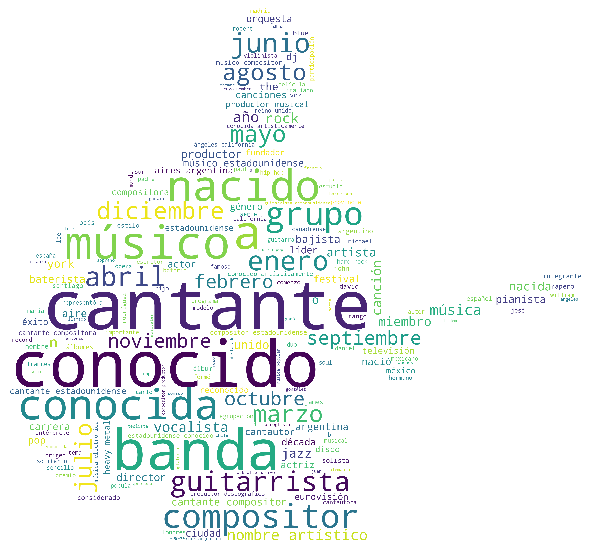

In [185]:
def plot_wordcloud(tokens_list, stopwords, mask, file_name):
    
    #comment_words = '' 
    comment_words = " ".join(tokens_list)

    wordcloud = WordCloud(width = 1024, height = 720, 
                    background_color ='white', 
                    stopwords = stopwords, 
                    min_font_size = 10,
                    mask=mask).generate(comment_words)
    
    wordcloud.to_file('../Images/'+file_name+".png")
    # plot the WordCloud image
    
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()
    
####

stopwords = spacy.lang.es.stop_words.STOP_WORDS
stopwords.add('y')
plot_wordcloud(token_list, stopwords, transformed_wiki_mask, 'wikimusica_wordcloud')

### Generos

In [ ]:
generos_l = df_wikimusica[df_wikimusica['variable']=='genero']['value'].tolist()
generos_l = [g.lower() for g in generos_l]

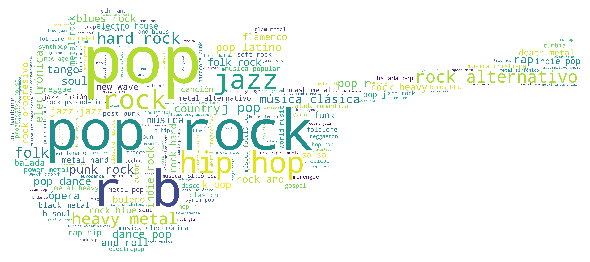

In [173]:
plot_wordcloud(generos_l, stopwords, transformed_guitar_mask, 'generos_wordcloud')

### Create vocabulary

In [14]:
vocabulary = set()
for t in token_list:
    vocabulary.add(t)

len(vocabulary)

43729

In [15]:
for ind,v in enumerate(vocabulary):
    
    if ind>200:
        break
    print(v)

dupla
barusso
213
sónico
chamamaan
otra
kent
sóley
eternal
traketero
muidikay
christoforou
expresada
celtes
shakedown
хелена
boyzone
petro
popularizó
lichinchi
lamontagne
for
farmacéutica
hacedor
riestra
роман
ukiah
excelente
kutxi
padecen
vasta
delta
sovetsk
ª
fellatio
ñico
almendralejo
naïm
notas
vanna
orjales
עווד
shaddix
milas
samso
1972-brooklyn
lovering
laan
malene
prefería
minutes
almendral
1989
yngve
yoshiki
duetos
mcaloon
islanders
malaya
tota
músicos
владимир
hajiyeva
thurrock
pohjola
ensenada
mindy
cinematográficas
liú
dirk
ube
take
nohemí
ward
інна
laval
robillard
rangga
des'ree
mathangi
sostenida
hits
aleksić
buturlina
baylor
druso
hokkaido
kanye
ilya
moloney
p.o.d.
arimany
última
inimitable
porros
floors
every
weeks
parcial
madeleine
timidez
melcarne
sabio
diouma
velocidades
ريميتي
irse
cramps
ceshia
cervila
chungha
exterior
cass
proponen
tarbolton
palma
1926-
rainbows
vader
gob.
acri
mixteca
moritz
valerio
tiritando
roni
urzúa
kindergarten
sabater
agustín
honrado
rouge
b

### Describing attributes

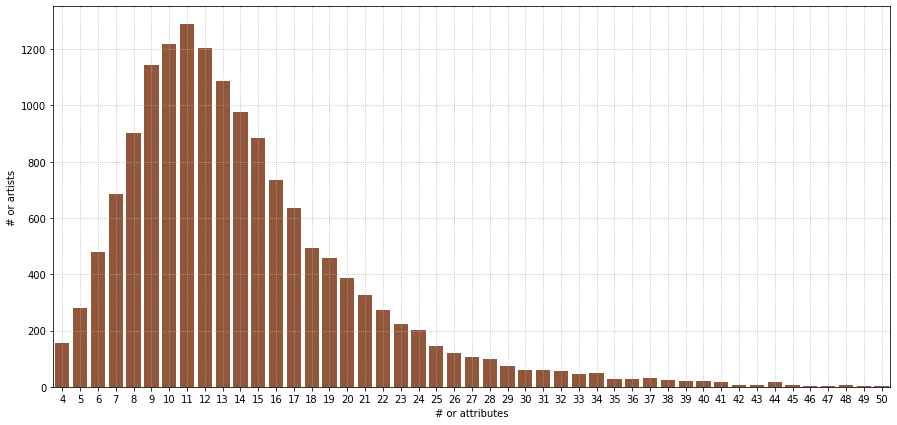

In [17]:
df_attr_per_artist = pd.DataFrame(df_wikimusica.groupby('_id_').count()['_titulo_']).rename(columns={'_titulo_': '#_attr'})

attr_per_artist = df_attr_per_artist.reset_index().groupby('#_attr').count().reset_index()
attr_per_artist = attr_per_artist[attr_per_artist['#_attr']<51]

ax = plt.figure(figsize=(15,7))

sns.barplot(attr_per_artist['#_attr'], attr_per_artist['_id_'], color='sienna');

plt.grid(linestyle=':')
plt.ylabel('# or artists')
plt.xlabel('# or attributes')
plt.show()

### Dataset full description

In [22]:
# Create dataset description

def describe_dataset(df):

    df_plot = df.copy()
    df_plot_II = df.copy()

    df_plot = pd.DataFrame(df_plot
                            .groupby(['_id_','variable'])
                            .head(1).groupby('variable')
                            .count()['_id_']
                            .sort_values(ascending=False)).rename(columns={'_id_':'# of artists'})

    df_plot['% of artists'] = df_plot.apply(lambda a: round(100*(a/15000),2))


    df_plot_II = pd.DataFrame(df_plot_II
                                      .groupby('variable')
                                      .count()['_id_']
                                      .sort_values(ascending=False)).rename(columns={'_id_':'# total'})

    df_plot = df_plot_II.merge(df_plot, 'left',  'variable')
    df_plot['mean per artist'] = round((df_plot['# total']/df_plot['# of artists']),2)

    median_df = pd.DataFrame(df
                  .groupby(['_id_','variable'])
                  .count()
                  .groupby('variable')
                  .median()['_titulo_']).rename(columns={'_titulo_':'median per artist'})

    df_plot = df_plot.merge(median_df, 'left',  'variable')

    df_plot = df_plot.filter(['# of artists', '% of artists', '# total', 'mean per artist', 'median per artist'])
    df_plot = df_plot.sort_values('# of artists', ascending=False)

    return df_plot


####

df_description = describe_dataset(df_wikimusica)
df_description

In [ ]:
df_description = describe_dataset()
df_description

In [34]:
# Data...

datasets = ['long', 'long_fully_aligned', 'long_softly_aligned',
            'short', 'short_fully_aligned', 'short_softly_aligned']

dataset_version = datasets[4]

In [35]:
data = pickle.load(open('../Datasets/wikimusica_'+dataset_version+'.p', "rb"))

input_train = data[0]
input_test = data[1]
output_train = data[2]
output_test = data[3]

In [33]:
a = input_train[3]

for i in a.split('wikimusic: ')[1].split(' • '):
    print(i)

stagename | Sandie Shaw
birthname | Sandra Ann Goodrich
occupation | Cantante
birthdate | 26 de febrero de 1947
instrument | Voz


In [210]:
print(df_plot.to_latex())

\begin{tabular}{lrrrrr}
\toprule
{} &  \# of artists &  \% of artists &  \# total &  mean per artist &  median per artist \\
variable            &               &               &          &                  &                    \\
\midrule
nombre artistico    &         14480 &         96.53 &    20096 &             1.39 &                1.0 \\
genero              &         13337 &         88.91 &    29192 &             2.19 &                2.0 \\
ocupacion           &         12958 &         86.39 &    26161 &             2.02 &                2.0 \\
nacimiento fecha    &         12209 &         81.39 &    12209 &             1.00 &                1.0 \\
instrumento         &         11680 &         77.87 &    21724 &             1.86 &                1.0 \\
actividad           &         10748 &         71.65 &    10753 &             1.00 &                1.0 \\
nacimiento lugar    &         10658 &         71.05 &    22487 &             2.11 &                2.0 \\
nombre nacimiento 